In [3]:
# Creating  CNN model Architecture Using Pytorch 
# Importing all the necessary libraries 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sys
sys.path.append('../Utils')
import configs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, classification_report
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, models
from tqdm import tqdm
import time
import copy
import os
import random
import warnings
warnings.filterwarnings("ignore")


In [4]:
# Set UP the model 

class CNNC(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNC, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(self.fc1(out))
        out = self.fc2(out)
        return out



In [5]:
# Create Train AND Evaluate Functions 
def train_model(model, Trainloaders, EvaluateLoader,criterion, optimizer, num_epochs=25):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = Trainloaders
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = EvaluateLoader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
    print('Best val Acc: {:4f}'.format(best_acc))
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history

def Evaluate(model,TestLoader):
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(TestLoader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print("Accuracy:", accuracy_score(all_labels, all_preds))
    print("\nClassification Report",classification_report(all_labels, all_preds))
    return all_labels, all_preds 





In [6]:
# Data loading ,transforming and Augmentation 
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# split train into train and validation

train_dataset = datasets.ImageFolder(configs.MULTIVIEW_TRAIN_DIR, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = datasets.ImageFolder(configs.MULTIVIEW_TRAIN_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)    
# Initialize the model, criterion and optimizer
model = CNNC(num_classes=7)
criterion = nn.CrossEntropyLoss()   
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train the model
model, train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50)
# Evaluate the model
all_labels, all_preds = Evaluate(model, test_loader)







Epoch 0/49
----------


100%|██████████| 88/88 [00:01<00:00, 50.82it/s]


train Loss: 1.6010 Acc: 0.3799


100%|██████████| 88/88 [00:00<00:00, 103.78it/s]


val Loss: 1.3214 Acc: 0.4614
Epoch 1/49
----------


100%|██████████| 88/88 [00:01<00:00, 64.81it/s]


train Loss: 1.3198 Acc: 0.4675


100%|██████████| 88/88 [00:00<00:00, 94.59it/s] 


val Loss: 1.1503 Acc: 0.5487
Epoch 2/49
----------


100%|██████████| 88/88 [00:01<00:00, 63.46it/s]


train Loss: 1.2269 Acc: 0.5084


100%|██████████| 88/88 [00:00<00:00, 89.11it/s]


val Loss: 1.1093 Acc: 0.5458
Epoch 3/49
----------


100%|██████████| 88/88 [00:01<00:00, 59.15it/s]


train Loss: 1.1884 Acc: 0.5275


100%|██████████| 88/88 [00:00<00:00, 99.70it/s] 


val Loss: 1.0713 Acc: 0.5731
Epoch 4/49
----------


100%|██████████| 88/88 [00:01<00:00, 69.94it/s]


train Loss: 1.1239 Acc: 0.5408


100%|██████████| 88/88 [00:00<00:00, 102.67it/s]


val Loss: 0.9887 Acc: 0.6061
Epoch 5/49
----------


100%|██████████| 88/88 [00:01<00:00, 70.33it/s]


train Loss: 1.0960 Acc: 0.5526


100%|██████████| 88/88 [00:00<00:00, 102.75it/s]


val Loss: 0.9480 Acc: 0.6237
Epoch 6/49
----------


100%|██████████| 88/88 [00:01<00:00, 63.92it/s]


train Loss: 1.0621 Acc: 0.5810


100%|██████████| 88/88 [00:00<00:00, 99.62it/s] 


val Loss: 0.9273 Acc: 0.6201
Epoch 7/49
----------


100%|██████████| 88/88 [00:01<00:00, 70.63it/s]


train Loss: 1.0373 Acc: 0.5864


100%|██████████| 88/88 [00:00<00:00, 101.42it/s]


val Loss: 1.0528 Acc: 0.5878
Epoch 8/49
----------


100%|██████████| 88/88 [00:01<00:00, 70.03it/s]


train Loss: 1.0439 Acc: 0.5853


100%|██████████| 88/88 [00:00<00:00, 99.71it/s] 


val Loss: 1.0012 Acc: 0.5975
Epoch 9/49
----------


100%|██████████| 88/88 [00:01<00:00, 70.19it/s]


train Loss: 0.9566 Acc: 0.6154


100%|██████████| 88/88 [00:00<00:00, 97.26it/s]


val Loss: 0.8030 Acc: 0.6898
Epoch 10/49
----------


100%|██████████| 88/88 [00:01<00:00, 64.01it/s]


train Loss: 0.9370 Acc: 0.6212


100%|██████████| 88/88 [00:01<00:00, 79.17it/s]


val Loss: 1.0118 Acc: 0.6000
Epoch 11/49
----------


100%|██████████| 88/88 [00:01<00:00, 60.20it/s]


train Loss: 0.9419 Acc: 0.6172


100%|██████████| 88/88 [00:00<00:00, 96.78it/s]


val Loss: 1.0485 Acc: 0.5670
Epoch 12/49
----------


100%|██████████| 88/88 [00:01<00:00, 64.42it/s]


train Loss: 0.9263 Acc: 0.6302


100%|██████████| 88/88 [00:01<00:00, 80.89it/s]


val Loss: 0.8495 Acc: 0.6700
Epoch 13/49
----------


100%|██████████| 88/88 [00:01<00:00, 65.72it/s]


train Loss: 0.9466 Acc: 0.6334


100%|██████████| 88/88 [00:00<00:00, 100.62it/s]


val Loss: 0.9555 Acc: 0.6187
Epoch 14/49
----------


100%|██████████| 88/88 [00:01<00:00, 60.93it/s]


train Loss: 0.8800 Acc: 0.6492


100%|██████████| 88/88 [00:00<00:00, 98.97it/s]


val Loss: 0.7360 Acc: 0.7031
Epoch 15/49
----------


100%|██████████| 88/88 [00:01<00:00, 65.02it/s]


train Loss: 0.8526 Acc: 0.6564


100%|██████████| 88/88 [00:00<00:00, 96.59it/s]


val Loss: 0.7292 Acc: 0.7059
Epoch 16/49
----------


100%|██████████| 88/88 [00:01<00:00, 66.44it/s]


train Loss: 0.7882 Acc: 0.6855


100%|██████████| 88/88 [00:00<00:00, 97.56it/s]


val Loss: 0.6819 Acc: 0.7296
Epoch 17/49
----------


100%|██████████| 88/88 [00:01<00:00, 67.30it/s]


train Loss: 0.8019 Acc: 0.6715


100%|██████████| 88/88 [00:00<00:00, 99.82it/s] 


val Loss: 0.7848 Acc: 0.6804
Epoch 18/49
----------


100%|██████████| 88/88 [00:01<00:00, 69.46it/s]


train Loss: 0.8048 Acc: 0.6711


100%|██████████| 88/88 [00:00<00:00, 89.33it/s]


val Loss: 0.6779 Acc: 0.7282
Epoch 19/49
----------


100%|██████████| 88/88 [00:01<00:00, 67.91it/s]


train Loss: 0.8294 Acc: 0.6772


100%|██████████| 88/88 [00:00<00:00, 97.12it/s]


val Loss: 0.6701 Acc: 0.7390
Epoch 20/49
----------


100%|██████████| 88/88 [00:01<00:00, 69.56it/s]


train Loss: 0.7247 Acc: 0.7070


100%|██████████| 88/88 [00:00<00:00, 98.80it/s]


val Loss: 0.6581 Acc: 0.7336
Epoch 21/49
----------


100%|██████████| 88/88 [00:01<00:00, 69.26it/s]


train Loss: 0.7033 Acc: 0.7246


100%|██████████| 88/88 [00:00<00:00, 98.71it/s]


val Loss: 0.6580 Acc: 0.7364
Epoch 22/49
----------


100%|██████████| 88/88 [00:01<00:00, 69.20it/s]


train Loss: 0.6613 Acc: 0.7533


100%|██████████| 88/88 [00:00<00:00, 98.71it/s]


val Loss: 0.6583 Acc: 0.7271
Epoch 23/49
----------


100%|██████████| 88/88 [00:01<00:00, 69.30it/s]


train Loss: 0.6648 Acc: 0.7300


100%|██████████| 88/88 [00:00<00:00, 97.73it/s]


val Loss: 0.6339 Acc: 0.7372
Epoch 24/49
----------


100%|██████████| 88/88 [00:01<00:00, 69.28it/s]


train Loss: 0.6882 Acc: 0.7178


100%|██████████| 88/88 [00:00<00:00, 97.76it/s]


val Loss: 0.8046 Acc: 0.6689
Epoch 25/49
----------


100%|██████████| 88/88 [00:01<00:00, 68.91it/s]


train Loss: 0.7445 Acc: 0.7178


100%|██████████| 88/88 [00:00<00:00, 99.09it/s] 


val Loss: 0.5133 Acc: 0.8104
Epoch 26/49
----------


100%|██████████| 88/88 [00:01<00:00, 69.08it/s]


train Loss: 0.6432 Acc: 0.7540


100%|██████████| 88/88 [00:00<00:00, 97.66it/s]


val Loss: 0.5277 Acc: 0.8011
Epoch 27/49
----------


100%|██████████| 88/88 [00:01<00:00, 68.80it/s]


train Loss: 0.6684 Acc: 0.7433


100%|██████████| 88/88 [00:00<00:00, 97.18it/s]


val Loss: 0.5786 Acc: 0.7691
Epoch 28/49
----------


100%|██████████| 88/88 [00:01<00:00, 68.60it/s]


train Loss: 0.7424 Acc: 0.7253


100%|██████████| 88/88 [00:00<00:00, 98.94it/s]


val Loss: 0.5869 Acc: 0.7612
Epoch 29/49
----------


100%|██████████| 88/88 [00:01<00:00, 68.95it/s]


train Loss: 0.6093 Acc: 0.7562


100%|██████████| 88/88 [00:00<00:00, 97.86it/s]


val Loss: 0.5029 Acc: 0.8140
Epoch 30/49
----------


100%|██████████| 88/88 [00:01<00:00, 68.65it/s]


train Loss: 0.6990 Acc: 0.7311


100%|██████████| 88/88 [00:00<00:00, 97.55it/s]


val Loss: 0.4675 Acc: 0.8345
Epoch 31/49
----------


100%|██████████| 88/88 [00:01<00:00, 67.97it/s]


train Loss: 0.5576 Acc: 0.7860


100%|██████████| 88/88 [00:00<00:00, 98.27it/s]


val Loss: 0.4684 Acc: 0.8305
Epoch 32/49
----------


100%|██████████| 88/88 [00:01<00:00, 68.02it/s]


train Loss: 0.5222 Acc: 0.7903


100%|██████████| 88/88 [00:00<00:00, 95.92it/s]


val Loss: 0.5498 Acc: 0.7777
Epoch 33/49
----------


100%|██████████| 88/88 [00:01<00:00, 67.96it/s]


train Loss: 0.5454 Acc: 0.7846


100%|██████████| 88/88 [00:00<00:00, 97.76it/s]


val Loss: 0.4614 Acc: 0.8165
Epoch 34/49
----------


100%|██████████| 88/88 [00:01<00:00, 68.03it/s]


train Loss: 0.5320 Acc: 0.7957


100%|██████████| 88/88 [00:00<00:00, 96.85it/s]


val Loss: 0.4121 Acc: 0.8442
Epoch 35/49
----------


100%|██████████| 88/88 [00:01<00:00, 60.05it/s]


train Loss: 0.5260 Acc: 0.7806


100%|██████████| 88/88 [00:00<00:00, 94.18it/s]


val Loss: 0.5634 Acc: 0.7738
Epoch 36/49
----------


100%|██████████| 88/88 [00:01<00:00, 64.04it/s]


train Loss: 0.5061 Acc: 0.8025


100%|██████████| 88/88 [00:01<00:00, 72.82it/s]


val Loss: 0.3759 Acc: 0.8492
Epoch 37/49
----------


100%|██████████| 88/88 [00:01<00:00, 45.67it/s]


train Loss: 0.5702 Acc: 0.7763


100%|██████████| 88/88 [00:01<00:00, 69.47it/s]


val Loss: 0.4500 Acc: 0.8248
Epoch 38/49
----------


100%|██████████| 88/88 [00:01<00:00, 57.28it/s]


train Loss: 0.5407 Acc: 0.7961


100%|██████████| 88/88 [00:01<00:00, 84.48it/s]


val Loss: 0.3543 Acc: 0.8643
Epoch 39/49
----------


100%|██████████| 88/88 [00:01<00:00, 61.09it/s]


train Loss: 0.4199 Acc: 0.8434


100%|██████████| 88/88 [00:01<00:00, 80.78it/s]


val Loss: 0.3253 Acc: 0.8783
Epoch 40/49
----------


100%|██████████| 88/88 [00:01<00:00, 49.73it/s]


train Loss: 0.4214 Acc: 0.8334


100%|██████████| 88/88 [00:01<00:00, 80.17it/s]


val Loss: 0.2995 Acc: 0.9013
Epoch 41/49
----------


100%|██████████| 88/88 [00:01<00:00, 55.08it/s]


train Loss: 0.4039 Acc: 0.8427


100%|██████████| 88/88 [00:00<00:00, 88.39it/s]


val Loss: 0.3299 Acc: 0.8815
Epoch 42/49
----------


100%|██████████| 88/88 [00:01<00:00, 63.11it/s]


train Loss: 0.4016 Acc: 0.8413


100%|██████████| 88/88 [00:00<00:00, 97.20it/s]


val Loss: 0.2607 Acc: 0.9149
Epoch 43/49
----------


100%|██████████| 88/88 [00:01<00:00, 64.97it/s]


train Loss: 0.3809 Acc: 0.8517


100%|██████████| 88/88 [00:00<00:00, 97.55it/s]


val Loss: 0.3544 Acc: 0.8503
Epoch 44/49
----------


100%|██████████| 88/88 [00:01<00:00, 67.62it/s]


train Loss: 0.3596 Acc: 0.8650


100%|██████████| 88/88 [00:00<00:00, 91.30it/s]


val Loss: 1.7043 Acc: 0.5828
Epoch 45/49
----------


100%|██████████| 88/88 [00:01<00:00, 59.18it/s]


train Loss: 0.8470 Acc: 0.7117


100%|██████████| 88/88 [00:01<00:00, 85.69it/s]


val Loss: 0.5349 Acc: 0.7892
Epoch 46/49
----------


100%|██████████| 88/88 [00:01<00:00, 61.11it/s]


train Loss: 0.4312 Acc: 0.8341


100%|██████████| 88/88 [00:00<00:00, 88.91it/s]


val Loss: 0.3117 Acc: 0.8887
Epoch 47/49
----------


100%|██████████| 88/88 [00:01<00:00, 62.07it/s]


train Loss: 0.3664 Acc: 0.8585


100%|██████████| 88/88 [00:01<00:00, 84.00it/s]


val Loss: 0.2768 Acc: 0.9038
Epoch 48/49
----------


100%|██████████| 88/88 [00:01<00:00, 59.31it/s]


train Loss: 0.3333 Acc: 0.8722


100%|██████████| 88/88 [00:00<00:00, 96.41it/s]


val Loss: 0.4548 Acc: 0.7953
Epoch 49/49
----------


100%|██████████| 88/88 [00:01<00:00, 57.68it/s]


train Loss: 0.5233 Acc: 0.7935


100%|██████████| 88/88 [00:00<00:00, 97.18it/s]


val Loss: 0.2632 Acc: 0.9110
Best val Acc: 0.914901


100%|██████████| 88/88 [00:00<00:00, 98.77it/s]

Accuracy: 0.910951526032316

Classification Report               precision    recall  f1-score   support

           0       0.91      0.89      0.90       160
           1       0.96      0.95      0.95       660
           2       0.86      0.92      0.89       735
           3       0.99      1.00      0.99        90
           4       0.98      0.97      0.97       100
           5       0.87      0.98      0.92       405
           6       0.94      0.80      0.87       635

    accuracy                           0.91      2785
   macro avg       0.93      0.93      0.93      2785
weighted avg       0.91      0.91      0.91      2785



In [7]:
# Print all model evaluation metrics 
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Balanced Accuracy:", balanced_accuracy_score(all_labels, all_preds))
print("F1 Score:", f1_score(all_labels, all_preds, average='weighted'))
print("Precision:", precision_score(all_labels, all_preds, average='weighted'))


Accuracy: 0.910951526032316
Balanced Accuracy: 0.9305352518100255
F1 Score: 0.9103220060499867
Precision: 0.9135389875585037


In [8]:
# calculate models parameters 
import utils as ut 
params = ut.count_dl_parameters(model) 
print(f"Total Parameters: {params['total_params']}")
print(f"Trainable Parameters: {params['trainable_params']}")

Total Parameters: 206631
Trainable Parameters: 206631


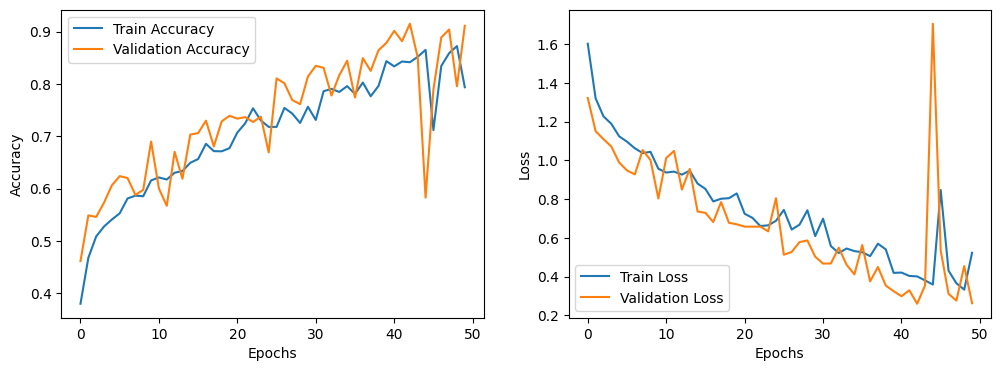

In [15]:

# plot training and validation accuracy and loss 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')    
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./plot/04_CNN_training_validation_accuracy_loss.png')
plt.show()






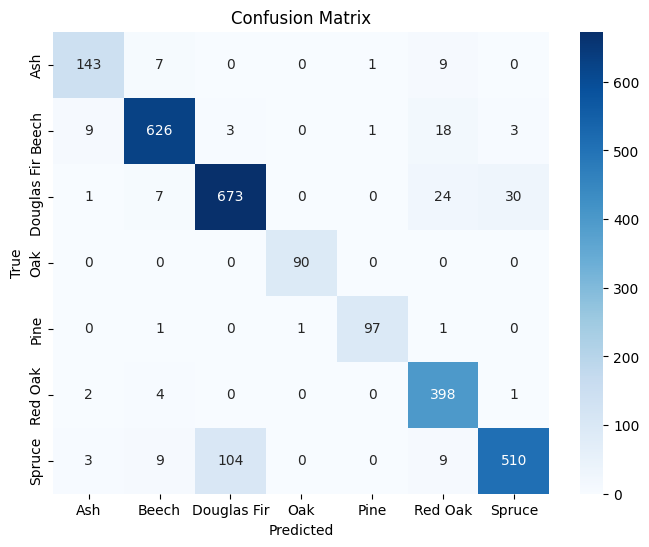

In [16]:
# plot confusion matrix 
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted') 
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('./plot/04_CNN_Confusion_Matrix.png')
plt.show()


In [22]:
from torchviz import make_dot

model = CNNC(num_classes=2)
dummy_input = torch.randn(1, 1, 28, 28) 
output = model(dummy_input)

dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("cnn_architecture_graph", format="png", cleanup=True)

'cnn_architecture_graph.png'